In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from load_utils import *

In [6]:
d = load_diffs()
df_events, df_blocked_user_text = load_block_events_and_users()

# Quantifying Prevalence of Personal Attacks

### Q: What fraction of comments are personal attacks?

Methodology 1:
Let p be the proportion of comments that where labled as a personal attack by more than half the annotators. 
Treat p as a random variable, with a weak/uniform beta prior. Compute posterior distribution of p using the number of comments and the number of comments labeled as attacks. Form 95% credible interval using the posterior.

In [51]:
from numpy.random import  beta

def get_credible_interval(num_events, num_trials, conf, num_samples = 50000):
    dist = beta(num_events+1, num_trials-num_events+1, num_samples)
    lower = (100.0 - conf)/2.0
    upper = conf + lower
    t = tuple(np.percentile(dist, [lower, upper]) * 100)
    print("Percent of comments labeled as attacks: (%.4f, %.4f)" % t)
    

In [52]:
# annotators:

df = d['annotated']
print('user + article:')
get_credible_interval(df['recipient'].sum(), df.shape[0], 95)

print('user:')
df = d['annotated'].query("ns=='user'")
get_credible_interval(df['recipient'].sum(), df.shape[0], 95)

print('article')
df = d['annotated'].query("ns=='article'")
get_credible_interval(df['recipient'].sum(), df.shape[0], 95)

user + article:
Percent of comments labeled as attacks: (0.5286, 0.6807)
user:
Percent of comments labeled as attacks: (0.6857, 0.9316)
article
Percent of comments labeled as attacks: (0.3216, 0.4977)


In [53]:
# model on annotator data Note: this is currently not kosher since the model was trained on this data

df = d['annotated']
print('user + article:')
get_credible_interval(df['pred_recipient'].sum(), df.shape[0], 95)

print('user:')
df = d['annotated'].query("ns=='user'")
get_credible_interval(df['pred_recipient'].sum(), df.shape[0], 95)

print('article')
df = d['annotated'].query("ns=='article'")
get_credible_interval(df['pred_recipient'].sum(), df.shape[0], 95)

user + article:
Percent of comments labeled as attacks: (0.2416, 0.3478)
user:
Percent of comments labeled as attacks: (0.3349, 0.5140)
article
Percent of comments labeled as attacks: (0.1173, 0.2315)


In [54]:
# model sample data: Not really meaninggful, just a comparison
df = d['sample']
print('user + article:')
get_credible_interval(df['pred_recipient'].sum(), df.shape[0], 95)

print('user:')
df = d['annotated'].query("ns=='user'")
get_credible_interval(df['pred_recipient'].sum(), df.shape[0], 95)

print('article')
df = d['annotated'].query("ns=='article'")
get_credible_interval(df['pred_recipient'].sum(), df.shape[0], 95)

user + article:
Percent of comments labeled as attacks: (0.3047, 0.3246)
user:
Percent of comments labeled as attacks: (0.3356, 0.5144)
article
Percent of comments labeled as attacks: (0.1180, 0.2316)


Methodology 2: Compute fraction of comments predicted to be attacks for different classification thresholds

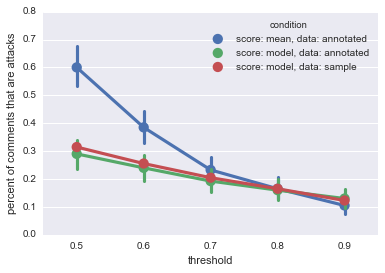

In [63]:
ts = np.arange(0.5, 0.91, 0.1)

# score = mean of annotations
d_aa = pd.concat([pd.DataFrame({'threshold': t, 'attack': d['annotated']['recipient_score'] >= t }) for t in ts], axis = 0)
d_aa['condition'] = 'score: mean, data: annotated'

# score = model score on annotated data
d_ma = pd.concat([pd.DataFrame({'threshold': t, 'attack': d['annotated']['pred_recipient_score'] >= t }) for t in ts], axis = 0) 
d_ma['condition'] = 'score: model, data: annotated'

# score = model score on sample data
d_ms = pd.concat([pd.DataFrame({'threshold': t, 'attack': d['sample']['pred_recipient_score'] > t }) for t in ts], axis = 0) 
d_ms['condition'] = 'score: model, data: sample' 

df = pd.concat([d_aa, d_ma, d_ms])
df['attack'] = df['attack'] * 100
sns.pointplot(x="threshold", y="attack", hue="condition", data=df)
plt.ylabel('percent of comments that are attacks')

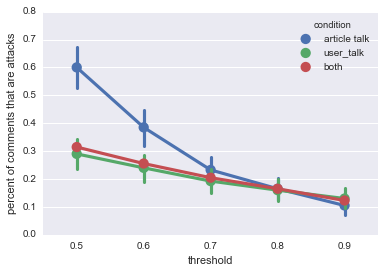

In [62]:
ts = np.arange(0.5, 0.91, 0.1)

# score = mean of annotations
d_a = pd.concat([pd.DataFrame({'threshold': t, 'attack': d['annotated']['recipient_score'] >= t }) for t in ts], axis = 0)
d_a['condition'] = 'article talk'

# score = model score on annotated data
d_u = pd.concat([pd.DataFrame({'threshold': t, 'attack': d['annotated']['pred_recipient_score'] >= t }) for t in ts], axis = 0) 
d_u['condition'] = 'user talk'

# score = model score on sample data
d_au = pd.concat([pd.DataFrame({'threshold': t, 'attack': d['sample']['pred_recipient_score'] > t }) for t in ts], axis = 0) 
d_au['condition'] = 'both' 

df = pd.concat([d_a, d_u, d_au])
df['attack'] = df['attack'] * 100
sns.pointplot(x="threshold", y="attack", hue="condition", data=df.sa)
plt.ylabel('percent of comments that are attacks')

Methodology 3: 
For each comment, label it as a personal attack with the probability assigned by the model/annotators. Count the number of comments labeled as personal attacks. Repeat to get a distribtion and take 95% interval.

In [75]:
def compute_ci(a, n = 1000):
    m = a.shape[0]
    v = a.values.reshape((m,1))
    fs = np.sum(np.random.rand(m, n) < v, axis = 0) / m
    print("Fraction of comments labeled as attacks: (%.4f, %.4f)" % ( np.percentile(fs, 2.5), np.percentile(fs, 97.5)))
    
    
# annotator probs
print('Scores: mean annotation, Data: annotated')
compute_ci(d['annotated']['recipient_score'])

# model probs on annotator data
print('Scores: model, Data: annotated')
compute_ci(d['annotated']['pred_recipient_score'])

# model on sample data
print('Scores: model, Data: sample')
compute_ci(d['sample']['pred_recipient_score'])

Scores: mean annotation, Data: annotated
Fraction of comments labeled as attacks: (0.0364, 0.0413)
Scores: model, Data: annotated
Fraction of comments labeled as attacks: (0.0331, 0.0379)
Scores: model, Data: sample
Fraction of comments labeled as attacks: (0.0354, 0.0362)


### Q: What fraction of users have made a personal attack?

Methodology 1: Take unsampled data. Compute fraction of people who authored one comment above the threshold for different thresholds.

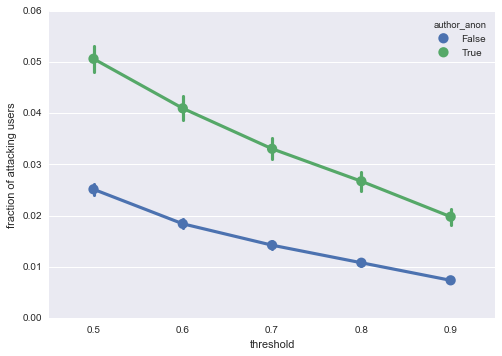

In [77]:
ts = np.arange(0.5, 0.91, 0.1)
dfs = []

for t in ts:
    
    dfs.append (\
                d['2015'].assign(attack= lambda x: x.pred_recipient_score > t)\
                .groupby(['user_text', 'author_anon'], as_index = False)['attack'].max()\
                .assign(threshold = t)
                )
sns.pointplot(x='threshold', y = 'attack', hue = 'author_anon', data = pd.concat(dfs))
plt.ylabel('fraction of attacking users')

Methodology 2: Take unsampled data. For each comment, let it be an attack with proabbility equal to the model prediction. Count the number of users that have made at least 1 attack. Repeat.

In [79]:
def simulate_num_attacks(df, group_col = 'user_text', bias = 0.0):
    n = df.assign( uniform = np.random.rand(df.shape[0], 1))\
            .assign(is_attack = lambda x: ((x.pred_recipient_score + bias) > x.uniform).astype(int))\
            .groupby(group_col)['is_attack']\
            .max()\
            .sum()
    return n

In [80]:
n_attacks = [simulate_num_attacks(d['2015']) for i in range(100)]        
np.percentile(n_attacks, [2.5, 97.5]) / len(d['2015'].user_text.unique())  

array([ 0.13261797,  0.13556789])

In [81]:
# ignore anon users
d_temp = d['2015'].query('not author_anon and not recipient_anon')
n_attacks = [simulate_num_attacks(d_temp) for i in range(100)]        
np.percentile(n_attacks, [2.5, 97.5]) / len(d_temp.user_text.unique())  

array([ 0.13692117,  0.14032371])

### Q: What fraction of users have been attacked?

Methodology: Take unsampled data. Compute fraction of people who recieved one comment above the threshold for different thresholds. TODO: why have there been so many more attackers and victims? Compute ratio of attacks received by user and order user by that ratio.


Note: do not include comments made by the user on their own page.

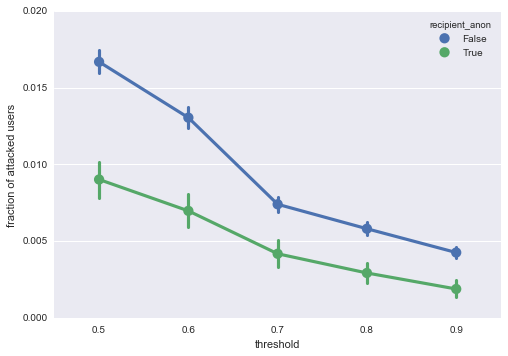

In [82]:
dfs = []

for t in ts:
    
    dfs.append (\
                d['2015'].query('not own_page')\
                .assign(attack = lambda x: x.pred_recipient_score >= t)\
                .groupby(['page_title', 'recipient_anon'], as_index = False)['attack'].max()\
                .assign(threshold = t)
                )
sns.pointplot(x='threshold', y = 'attack', hue = 'recipient_anon', data = pd.concat(dfs))
plt.ylabel('fraction of attacked users')

Methodology 2: Take unsampled data. For each comment, let it be an attack with probability equal to the model prediction. Count the number of users that have received at least 1 attack. Repeat.

In [83]:
n_attacks = [simulate_num_attacks(d['2015'], group_col = 'page_title') for i in range(10)]        
np.percentile(n_attacks, [2.5, 97.5]) / len(d['2015'].page_title.unique()) 

array([ 0.09798288,  0.09931467])

In [84]:
# ignore anon users
d_temp = d['2015'].query('not author_anon and not recipient_anon')
n_attacks = [simulate_num_attacks(d_temp, group_col = 'page_title') for i in range(10)]        
np.percentile(n_attacks, [2.5, 97.5]) / len(d_temp.page_title.unique()) 

array([ 0.1004873 ,  0.10291657])

### Q: What fraction of attacking comments come from users blocked for harassment?

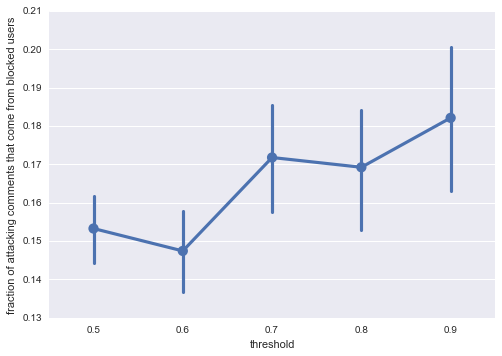

In [88]:
dfs = []


for t in ts:
    dfs.append(\
                d['2015'].query('pred_recipient_score >= %f' % t)[['rev_id', 'author_anon']]\
                .merge(d['blocked'], how = 'left', on = 'rev_id')\
                .assign(blocked = lambda x: x.blocked.fillna(0),
                        threshold = t)
               )
df = pd.concat(dfs)

sns.pointplot(x = 'threshold', y = 'blocked', data = df)
plt.ylabel('fraction of attacking comments that come from blocked users')